# Assignment 3

## Objective of this assignment
The objective of this exercise is to become familiar with fitting decision trees and
making ROC curves in Python.


## ** Important: ** When handing in your homework:
+ Hand in the notebook (and nothing else) named as follows: StudentName1_snumber_StudentName2_snumber.ipynb
+ Provide clear and complete answers to the questions below under a separate header (not hidden somewhere in your source code), and make sure to explain your answers / motivate your choices. Add Markdown cells where necessary.
+ Source code, output graphs, derivations, etc., should be included in the notebook.
+ Hand-in: upload to Brightspace.
+ Include name, student number, assignment (especially in filenames)!
+ When working in pairs only one of you should upload the assignment, and report the name of your partner in your filename.
+ For problems or questions: use the Brightspace discussion board or email the student assistants.


## Advised Reading and Exercise Material
**The following reading material is recommended:**

Pang-Ning Tan, Michael Steinbach, and Vipin Kumar, Introduction to Data Mining, section 4.1-4.6, as well as the included article on ROC curves.


## 3.1 Decision trees

In this part of the exercise we will fit decision trees using the scikitlearn classifier
`sklearn.tree.DecisionTreeClassifier`. As a splitting criterion, the function uses
one of the following two impurity measures:

\begin{equation} \textrm{gdi}(t) = -\sum_{i=1}^C p(i|t)^2 \quad \text{       equivalent to Gini(t)} \end{equation}   

\begin{equation}
\textrm{deviance}(t) = -2\sum_{i=1}^C p(i|t) \log p(i|t) \quad \text{equivalent to Entropy(t)} 
\end{equation}

We will analyze the wine data we have used previously. The wine data set has the following attributes, all of which are continuous: 


| #             | Attribute     | Unit  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | g/dm$^3$ |
|2 | Volatile acidity (acetic) | g/dm$^3$ |
|3 | Citric acid | g/dm$^3$ |
|4 | Residual sugar | g/dm$^3$ |
|5 | Chlorides | g/dm$^3$ |
|6 | Free sulfur dioxide | mg/dm$^3$ |
|7 | Total sulfur dioxide | mg/dm$^3$ |
|8 | Density | g/cm$^3$ |
|9 | pH | pH |
|10 | Sulphates | g/dm$^3$ |
|11 | Alcohol | % vol. | 


#### 3.1.1
Load the wine data set `Data/wine.mat` using the `scipy.io` `loadmat` function. This contains the same data as used in the earlier assignment, but with outliers and the 12th attribute already removed. Create data matrix $X$, class vector $y$, and the vectors $attributeNames$ and $classNames$ with the data provided in the `wine.mat` file.

In [1]:
import numpy  as np
import matplotlib.pyplot as plt

import scipy
from scipy.io    import loadmat
from scipy.stats import binom

import sklearn
from sklearn.tree            import DecisionTreeClassifier as DTC
from sklearn.metrics         import accuracy_score         as AC
from sklearn.metrics         import roc_auc_score          as RAS
from sklearn.metrics         import roc_curve              as ROC
from sklearn.model_selection import cross_val_score        as CVS
from sklearn.model_selection import train_test_split       as TTS

from pandas import read_excel
from Toolbox.treeprint import tree_print

In [2]:
# Load wine data set
wine_data       = loadmat('Data/wine.mat')
X               = wine_data['X']
y               = wine_data['y'].ravel()
attribute_names = wine_data['attributeNames'].ravel()
class_names     = wine_data['classNames'].ravel()

# Print shapes
print('X shape:              ', X.shape)
print('y shape:              ', y.shape)
print('attribute_names shape:', attribute_names.shape)
print('class_names shape:    ', class_names.shape)

# Print wine data set
#print(X)
#print(y)
#print(attribute_names)
#print(class_names)

X shape:               (6304, 11)
y shape:               (6304,)
attribute_names shape: (11,)
class_names shape:     (2,)


#### 3.1.2
 (2 pts) Fit a decision tree to the wine data in order to estimate if the wine is red or white. Use the Gini (gdi) splitting criterion. Use `min_samples_split=100` for the stopping criterion. Explain what happens when you change the values of the parameter `min_samples_split`. After fitting the tree, visualize it with the tree_print function in `treeprint.py`.

In [3]:
msp = 100  # min_samples_split
md  = 6    # max_depth

# Fit tree classifier
dtc = DTC(criterion='gini', min_samples_split=msp, max_depth=md).fit(X, y)

# Print tree
tree_print(dtc, attribute_names, class_names)

         |->3  ['White']
         |
      |->2 then if ['Sulphates'] =< 0.56: go to 3, else go to 4
      |  |
      |  |->4  ['White']
      |
   |->1 then if ['Chlorides'] =< 0.05: go to 2, else go to 5
   |  |
   |  |  |->6  ['White']
   |  |  |
   |  |->5 else if ['Sulphates'] =< 0.37: go to 6, else go to 7
   |     |
   |     |  |->8  ['White']
   |     |  |
   |     |->7 else if ['Density'] =< 0.99: go to 8, else go to 9
   |        |
   |        |     |->11  ['White']
   |        |     |
   |        |  |->10 then if ['Residual sugar'] =< 1.10: go to 11, else go to 12
   |        |  |  |
   |        |  |  |->12  ['Red']
   |        |  |
   |        |->9 else if ['Residual sugar'] =< 10.70: go to 10, else go to 13
   |           |
   |           |->13  ['White']
   |
if ['Total sulfur dioxide'] =< 66.50: go to 1, else go to 14
   |
   |              |->19  ['White']
   |              |
   |           |->18 then if ['pH'] =< 3.84: go to 19, else go to 20
   |           |  |
   |   

`min_samples_split` ensures that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data.

#### 3.1.3

(0.5 pts) Show that a wine with the following attribute values would be classified as white by the tree fitted in 3.1.2. Which attributes are used to classify this wine?

| #             | Attribute     | Value  |
| ------------- |:-------------| -----:|
|1 | Fixed acidity (tartaric) | 6.9 g/dm$^3$ |
|2 | Volatile acidity (acetic) | 1.09 g/dm$^3$ |
|3 | Citric acid | 0.06 g/dm$^3$ |
|4 | Residual sugar | 2.1 g/dm$^3$ |
|5 | Chlorides | 0.0061 g/dm$^3$ |
|6 | Free sulfur dioxide | 12 mg/dm$^3$ |
|7 | Total sulfur dioxide | 31 mg/dm$^3$ |
|8 | Density | 0.99 g/cm$^3$ |
|9 | pH | 3.5 |
|10 | Sulphates | 0.64 g/dm$^3$ |
|11 | Alcohol | 12 % vol. |

In [4]:
# Classify type
x       = np.array([6.9,1.09,.06,2.1,.0061,12,31,.99,3.5,.64,12]).reshape(1,-1)
x_class = dtc.predict(x)

# Print class
print('Class:', class_names[x_class])

Class: [array(['White'], dtype='<U5')]


#### 3.1.4
(1 pts) Classify all the wines in the wine data set. What percentage of the wine data is classified correctly by the tree?



In [5]:
# Classify all wines
wine_class = np.array([], np.uint8)

for i in range(0,X[:,0].size):
    Xi         = X[i].reshape(1,-1)
    Xi_class   = dtc.predict(Xi)
    wine_class = np.append(wine_class, Xi_class)

# Print accuracy
acc = AC(y, wine_class)
print('Accuracy:', acc)

Accuracy: 0.9866751269035533


## 3.2 Decision tree pruning using cross-validation

In this exercise we will use cross-validation to prune a decision tree. When applying cross-validation the observed data is split into training and test sets, i.e., `X_train`, `y_train` and `X_test` and `y_test`. We train the model on the training data and evaluate the performance of the trained model on the test data.

#### 3.2.1
(2 pts) Load the wine data set `Data/wine.mat` using the `scipy.io` `loadmat` function. Divide the data into a training and a test data set. Fit a decision tree to the training data using the Gini (`gdi`) splitting criterion.

Now, we want to find an optimally pruned decision tree by *modifying its maximum depth*. For different values of the parameter `depth` (from 2 to 20), 
+ first fit the decision tree
+ then compute the classification error on the training and test set (this is called holdout cross-validation)

When you've done this for `depth` values 2,...,20, plot the training and test classification error as a function of the tree depth in the same figure. This will show us what the optimal pruning depth is for the training set, but also how well this generalizes to a test set. 

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data?


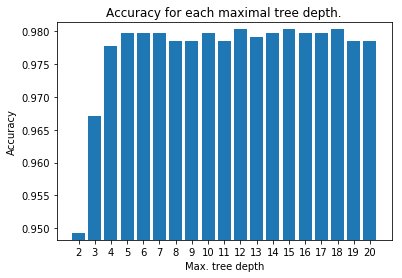

In [6]:
# Split into training and test sets
X_train, X_test, y_train, y_test = TTS(X, y)

# Fit tree classifier
scores = np.array([], np.uint8)
for i in range(2,21):
    dtc_i   = DTC(criterion='gini', min_samples_split=msp, max_depth=i).fit(X_train, y_train)
    score_i = dtc_i.score(X_test, y_test)
    scores  = np.append(scores, score_i)

# Make bar plot
pad   = .001
y_pos = np.arange(2,21)

plt.title ('Accuracy for each maximal tree depth.')
plt.xlabel('Max. tree depth')
plt.ylabel('Accuracy')
plt.ylim  ([min(scores)-pad, max(scores)+pad])
plt.xticks(y_pos)

plt.bar(y_pos, scores)
plt.show()

It appears that a tree depth of 6 would be the optimal depth, because before that the accuracy still increases a lot and after that, the accuracy barely changes any more. When running the code multiple times the graph can change quite a bit, but in most cases the accuracy keeps climbing until a value of 5 or 6. Also, in quite a lot of runs there is a small peak in the accuracy for a depth of 5 or 6.

#### 3.2.2
(1.5 pts) Repeat the exercise above, using 10-fold cross-validation. K-fold cross-validation works by splitting X into K partitions of equal length. Then in each fold, you choose K-1 partitions as the training set and the remaining partition as the test set. Every partition gets a turn being a test set. For a very nice simple explanation of how (and why) K-fold works, check out http://www.dummies.com/programming/big-data/data-science/resorting-cross-validation-machine-learning/


For each fold, fit a decision tree on the training set and evaluate its performance on the test set. Finally, compute the average classification errors on the test- and training sets across the 10 cross-validation folds and plot them as a function of the tree depth.

What appears to be the optimal tree depth? Do you get the same result when you run your code again, generating a new random split between training and test data? How about 100-fold cross-validation?

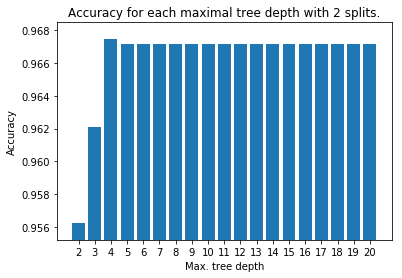

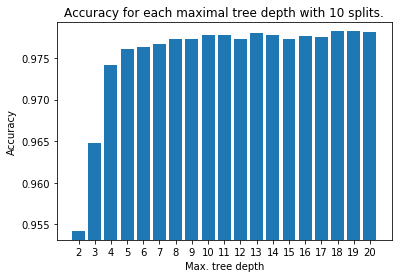

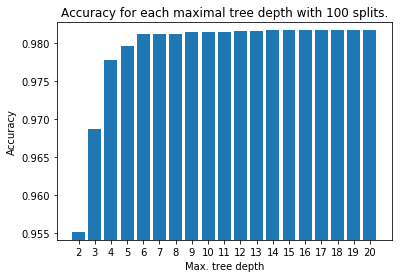

In [7]:
K = [2,10,100]  # folds

for i in range(len(K)):
    # Fit tree classifier
    kf_scores = np.array([], np.uint8)
    for j in range(2,21):
        dtc_j     = DTC(criterion="gini", min_samples_split=msp, max_depth=j)
        score_j   = CVS(estimator=dtc_j, X=X, y=y, cv=K[i])
        kf_scores = np.append(kf_scores, score_j.mean())

    # Make bar plot
    plt.title ('Accuracy for each maximal tree depth with %i splits.' %K[i])
    plt.xlabel('Max. tree depth')
    plt.ylabel('Accuracy')
    plt.ylim  ([min(kf_scores)-pad, max(kf_scores)+pad])
    plt.xticks(y_pos)
    
    plt.bar(y_pos, kf_scores)
    plt.show()

It still looks like a depth of 6 would be optimal, because before that the accuracy still increases a lot and after that, the accuracy barely changes any more. When running the code multiple times the outcomes don't change as much, especially when taking more splits. When increasing the amount of splits the bar plot becomes a lot smoother.

 ## 3.3 ROC curves, AUC scores, and the sign test

In this exercise we will use ROC curves and the sign test to compare classifiers. Study the lecture slides and the paper 'ROC Graphs: Notes and Practical Considerations for Researchers' by Tom Fawcett included with the homework assignment (ROC101.pdf). It describes all you need to know (and much, much more..) about ROC curves. The method explained for computing the area under the curve is unnecessarily complicated. A simpler formula is:
$$
    \mbox{AUC} = {1 \over m n} \sum_{i=1}^m \sum_{j=1}^n \mathbf{\large 1}_{p_i > p_j} \: .
$$
Here $i$ runs over all $m$ data points with true label 1, and $j$ runs over all $n$ data points with true label $0$; $p_i$ and $p_j$ denote the probability score assigned by the classifier to data point $i$ and $j$, respectively. $\mathbf{\large 1}$ is the indicator function: it outputs $1$ if the condition (here $p_i > p_j$) is satisfied and $0$ otherwise. *Simply put: this formula computes how often the probability of a data point with true label 1 is higher than the probability of data points with true label 0. This is then divided by the total number of comparisons between probabilities.*
    

#### 3.3.1
(0.25 pts) To make sure you understand how ROC works, you can make an ROC curve and calculate the AUC (on paper) with the following data:

`
labels = [0,0,0,1,0,1,1,0,1,1]
classifier_probs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
`
    
What's the AUC you calculated? Do you think this classifier works well?


The AUC I calculated on paper is: 0.84 <br>
I think this classifier works well, because it tells you a lot more than just the accuracy, which can be misleading.

#### 3.3.2
  Load the file `Data/classprobs.xls` using the Pandas `read_excel` function. Inspect the data and cast it to an array with the `as_matrix` function. The first column gives the true class label (either 0 or 1). The second and third column give the probabilistic scores for two different classifiers. The higher this probability, the more certain the classifier is that the example belongs to class 1 (instead of class 0).


In [8]:
# Load class probs data set
probs_data = read_excel('Data/classprobs.xls').values
true_class = probs_data[:,0]
pred1      = probs_data[:,1]
pred2      = probs_data[:,2]

# Print shapes
print('true_class shape:', true_class.shape)
print('pred1 shape:     ', pred1.shape)
print('pred2 shape:     ', pred2.shape)

# Print class probs data set
#print(true_class)
#print(pred1)
#print(pred2)

true_class shape: (107,)
pred1 shape:      (107,)
pred2 shape:      (107,)


#### 3.3.3
(1 pts) Calculate the ROC curves for both of the classifiers and plot them in the same plot. Also plot a dashed line on the diagonal to represent random guessing in the same figure. Interpret the obtained results. Do both classifiers perform better than random guessing?

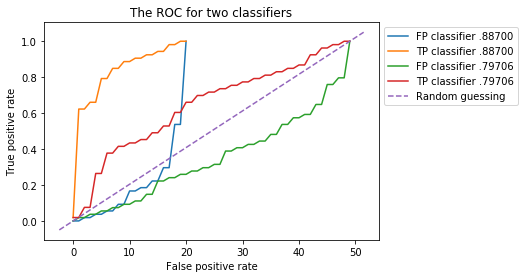

In [9]:
# Calculate ROC
FP1, TP1, thresh1 = ROC(true_class, pred1)
FP2, TP2, thresh2 = ROC(true_class, pred2)

# Define plot
f, ax = plt.subplots()
plt.title ('The ROC for two classifiers')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

# Make plot
ax.plot  (FP1, label='FP classifier .88700')
ax.plot  (TP1, label='TP classifier .88700')
ax.plot  (FP2, label='FP classifier .79706')
ax.plot  (TP2, label='TP classifier .79706')
ax.plot  (ax.get_xlim(), ax.get_ylim(), '--', label='Random guessing')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

Both classifiers perform better than random guessing. But the classifier 0.88700 is better because it has a steeper curve than the classifier 0.79706.

#### 3.3.4
(0.5 pts) Compute the AUC scores (area under the curve) of both classifiers using the formula given above. Write your own code for this calculation. Do the AUC scores indicate that the classifiers are performing better than this baseline?




 

In [10]:
# Calculate scores
score_pred1 = RAS(true_class, pred1)
score_pred2 = RAS(true_class, pred2)

# Print scores
print('Score pred1:', score_pred1)
print('Score pred2:', score_pred2)

Score pred1: 0.9556254367575123
Score pred2: 0.7613556953179594


The AUC scores do indeed perform better than the baseline. The AUC score of pred1 is better than the AUC score of pred2.


#### 3.3.5
(0.25 pts) Using a threshold of 0.5, translate the probability scores to predicted class labels, and compute the accuracy for each of the classifiers.

In [11]:
# ?

#### 3.3.6
(1 pts) Create the 2x2 table of wrong and correct classifications by the first and the second classifier, like in the lecture slides (lecture on model evaluation, part on the sign test). Perform a sign test to test whether the performance of the two classifiers is significantly different at a significance level of 0.05.

Pred1 has a better value 51 times, while pred2 has a better value 56 times.


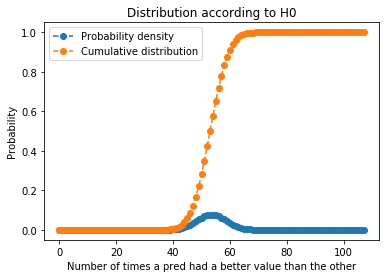

The p-value is 0.699


In [12]:
# Calculate values
N_pred1 = sum(pred1 > pred2)  # Lucky coin wins
N_pred2 = sum(pred1 < pred2)  # Random coin wins
N       = N_pred1 + N_pred2

# Print values
print('Pred1 has a better value {} times, while pred2 has a better value {} times.'.format(N_pred1, N_pred2))

# N: observations of inequality, p: prob one coin being better, which is 0.5 according to H0
b = binom(N, 0.5)

# Define plot
plt.title ('Distribution according to H0')
plt.xlabel('Number of times a pred had a better value than the other')
plt.ylabel('Probability')

# Make plot
plt.plot(b.pmf(range(N+1)), '--o', label='Probability density')
plt.plot(b.cdf(range(N+1)), '--o', label='Cumulative distribution')
plt.legend()
plt.show()

# Calculate p-value
p_value = b.cdf(min(N_pred1, N_pred2)) + (1-b.cdf(max(N_pred1, N_pred2)-1))

# Print p-value
print('The p-value is {:.3f}'.format(p_value))

## Example two-sided sign test

Imagine you have a lucky coin, that you are certain does not result in heads 50% of the times you flip it. However, you friend (lets call him *zero_hypothesis*) claims that your coin is just like his random coin. To verify whether this is true, you decide to compare the performance (you are a scientist after all) of your lucky coin resulting in heads to the performance of the random coin resulting in heads with a sign test. How do you do this?

First, you collect data. Assume you both used your coin during 23 bets. During those 23 bets, you both flip your respective coins. It was determined that if one of you flipped head while the other didn't, that person won the bet, and the other person lost. If you both got the same outcome, neither of you won. 1 stands for head, and 0 for tails. These were your results:

In [13]:
# Results
lucky_coin  = np.array([1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,1])
random_coin = np.array([0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0])

Now you calculate how often in any pair of outcomes one coin *won*, i.e. one coin flipped to head while the other flipped to tails.

In [14]:
# Calculate wins
N_l = sum((lucky_coin == 1) & (random_coin == 0))  # Lucky coin wins
N_r = sum((lucky_coin == 0) & (random_coin == 1))  # Random coin wins
N   = N_l + N_r

# Print wins
print('The lucky coin won {} times, while the random won {} times.'.format(N_l, N_r))

The lucky coin won 12 times, while the random won 3 times.


You observed 15 times that one coin won. If both coins resulted in heads 50% of the time, like *zero_hypothesis* stated, you'd expect that both coins have 50% chance of being the winner. So the probability distributions for both N_l and N_r should look something like this, assuming that *zero_hypothesis* is right:

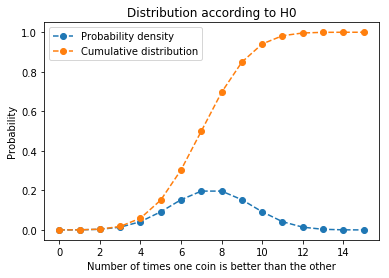

In [15]:
# N: observations of inequality, p: prob one coin being better, which is 0.5 according to H0
b = binom(N, 0.5)

# Define plot
plt.title ('Distribution according to H0')
plt.xlabel('Number of times one coin is better than the other')
plt.ylabel('Probability')

# Make plot
plt.plot(b.pmf(range(N+1)), '--o', label='Probability density')
plt.plot(b.cdf(range(N+1)), '--o', label='Cumulative distribution')
plt.legend()
plt.show()

(Of course this is a discrete probability function, so you're not interested in values between integers.)

As you can see, according to *zero_hypothesis*, 7 and 8 are the most likely values for both N_l and N_r. But this is not what you observed in your data. To conclude that *H0* is false, you need to show that your outcome is unlikely under the assumption that *H0* is true: the values you observed are so extreme that these values or more extreme values occur less than 5% of the time (*p-value < 0.05*). So how unlikely is it that one coin is better 12 times or more, and the other is better 3 times or less?

It's the sum of the values of the probability density function (pdf or pmf in the python doc) at  0,1,2 and 3, plus the sum of the values of the pdf at 12,13,14 and 15. 

This is equal to the value of the cumulative distribution function (cdf) at 3, plus 1 minus the value of cdf at 11 (since `1-cdf(11)` represents the probability of observing 12 or bigger).

In [16]:
# Calculate p-value
p_value = b.cdf(min(N_r, N_l)) + (1-b.cdf(max(N_r, N_l)-1))

# Print p-value
print('The p-value is {:.3f}'.format(p_value))

The p-value is 0.035


So your observations are very unlikely if *zero_hypothesis* is right. By statistical theory, you can now say that you have significant reason to reject their opinion. Now the hardest part of statistics: convincing your non-scientist friends.